<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/tpnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP réseau de neurones

### Objectif
L'objectif de ce tp est de se familiariser avec la paradigme essentielle de l'apprentissage par ordinateur : une base d'apprentissage pour apprendre et une base de test pour évaluer.

### Demarche
La demarche repose principalement sur la recherche de jeux de données apprentissage et test sur lesquels un algorithme fixé a un comportement demandé.

Indépendamment, l'ensemble du code étant modifiable, il invite à être modifié (l'algorithme principal peut notamment être remplacé par un plus proche voisin) pour explorer différemment ces notions. De plus la selection de la répartition train/test peut être faites aléatoirement à partir d'une distribution fixe.

### À noter
À noter qu'une version beaucoup plus "cool" peut être trouvé ici : https://playground.tensorflow.org avec le désavantage de mettre l'accent sur le réseau et non sur les données comme c'est l'objectif ici.

Néanmoins, compte tenu de la qualité de cette application (n'est pas google qui veut), le tp peut +/- être fait sur ce site plutôt que dans ce notebook.

## La boite noire

L'ensemble des fonctions ci dessous n'est pas voué à être comprise/modifié en première lecture.
Cela implémente une fonction qui étant donnée une base d'apprentissage et une base de test, réalise une apprentissage et une évaluation.

In [0]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import torch.autograd.variable

from matplotlib import pyplot as plt
from matplotlib import animation

def visualize_current_model_behaviour(trainingdata,testingdata,model):
    data = {}
    data["train"] = trainingdata
    data["test"] = testingdata
    
    grid = {}
    grid["train"] = np.ones((50,50,3),dtype=int)
    grid["test"] = np.ones((50,50,3),dtype=int)
    for traintest in ["train","test"]:
        X,Y = data[traintest]
        for i in range(X.shape[0]):
            row,col = X[i][0],X[i][1]
            if Y[i]==1:
                grid[traintest][row][col][0]=0
                grid[traintest][row][col][2]=0
            else:
                grid[traintest][row][col][0]=0
                grid[traintest][row][col][1]=0
    
    grid["alldata"] = grid["train"]*grid["test"]
    
    batch = np.zeros((50*50,2),dtype=float)
    for row in range(50):
        for col in range(50):
            batch[row*50+col][0]=row
            batch[row*50+col][1]=col
    prediction = model.getPredictedClass(batch)
    
    
    grid["pred"] = np.ones((50,50,3),dtype=int)*255
    for row in range(50):
        for col in range(50):
            if prediction[row*50+col] == 1:
                grid["pred"][row][col][0]=175
                grid["pred"][row][col][2]=175
            else:
                grid["pred"][row][col][0]=175
                grid["pred"][row][col][1]=175
    
    grid["train_error"] = np.ones((50,50,3),dtype=int)*255
    grid["test_error"] = np.ones((50,50,3),dtype=int)*255
    for traintest in ["train","test"]:
        X,Y = data[traintest]
        for i in range(X.shape[0]):
            row,col = X[i][0],X[i][1]
            if prediction[row*50+col] != Y[i]:
                grid[traintest+"_error"][row][col][1]=0
                grid[traintest+"_error"][row][col][2]=0
    
    for key in grid:
        grid[key][0,:,:]=0
        grid[key][49,:,:]=0
        grid[key][:,0,:]=0
        grid[key][0,49,:]=0
    
    tmp = np.concatenate((grid["alldata"]*255,grid["train"]*255,grid["test"]*255), axis=1)
    tmp2 = np.concatenate((grid["pred"],grid["train_error"],grid["test_error"]), axis=1)
    tmp3 = np.concatenate((tmp,tmp2),axis=0)
    return tmp3


def train_test_deep_network(trainingdata,testingdata,model,nbIteration):
    model.updateweights(trainingdata)
    
    displaysize = 20
    fig, ax = plt.subplots(figsize=(displaysize, displaysize))
    visu = visualize_current_model_behaviour(trainingdata,testingdata,model)
    imgplot = ax.imshow(visu)
    plt.ion()
    plt.show()
    plt.pause(0.001)

    for iteration in range(nbIteration-1):
        loss = model.updateweights(trainingdata)
        
        visu = visualize_current_model_behaviour(trainingdata,testingdata,model)
        imgplot.set_data(visu)
        plt.show()
        plt.pause(0.001)

    plt.pause(1)

 
class Net(nn.Module):
    def getPredictedClass(self,x):
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variableoutput = self.forward(variablex)
        prob = variableoutput.cpu().data.numpy()
        return np.argmax(prob,axis=1)
    
    def updateweights(self,batchfromtrain):
        x,y = batchfromtrain
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variabley = torch.autograd.Variable(torch.from_numpy(y).long())
        variableoutput = self.forward(variablex)
        
        loss = self.losslayer(variableoutput,variabley)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()        
        return loss.cpu().data.numpy()
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 30, bias=True)
        self.fc2 = nn.Linear(30, 30, bias=True)
        self.fc2bis = nn.Linear(30, 30, bias=True)
        self.fc3 = nn.Linear(30, 2, bias=True)
        
        self.train()
        
        
        self.lr = 0.1
        self.momentum = 0.5
        self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.losslayer = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x/30))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc2bis(x))
        x = self.fc3(x)
        return x
        
class NearestNeighbourg:
    def getPredictedClass(self,x):
        if len(x.shape)==1:        
            distances = [(np.sum((x-self.X[i])*(x-self.X[i])),i) for i in range(self.X.shape[0])]
            d,argmin = min(distances)
            return self.Y[argmin]
        else:
            y = [self.getPredictedClass(x[i]) for i in range(x.shape[0])]
            return np.asarray(y)
    
    def updateweights(self,x,y):
        self.X = x
        self.Y = y 


def data_from_grid_label(gridlabel):
    X,Y = [],[]
    tmp = np.zeros((1,2),dtype=int)
    for row in range(10):
        for col in range(10):
            tmp[0][0]=row*5+2
            tmp[0][1]=col*5+2
            if gridlabel[row][col] == '+':
                X.append(tmp.copy())
                Y.append(1)
            if gridlabel[row][col] == '-':
                X.append(tmp.copy())
                Y.append(0)
    return np.concatenate(X,axis=0),np.asarray(Y)

In [0]:
def observe_network_behaviour_on_griddata(gridlabeltrain,gridlabeltest):
    model = Net()
    trainingdata,testingdata = data_from_grid_label(gridlabeltrain),data_from_grid_label(gridlabeltest)
    train_test_deep_network(trainingdata,testingdata,model,300)

## Exemples d'apprentissage :

Faites tourner les 3 apprentissages ci dessous pour vous familiariser avec le code

### CAS 1 : linéaire

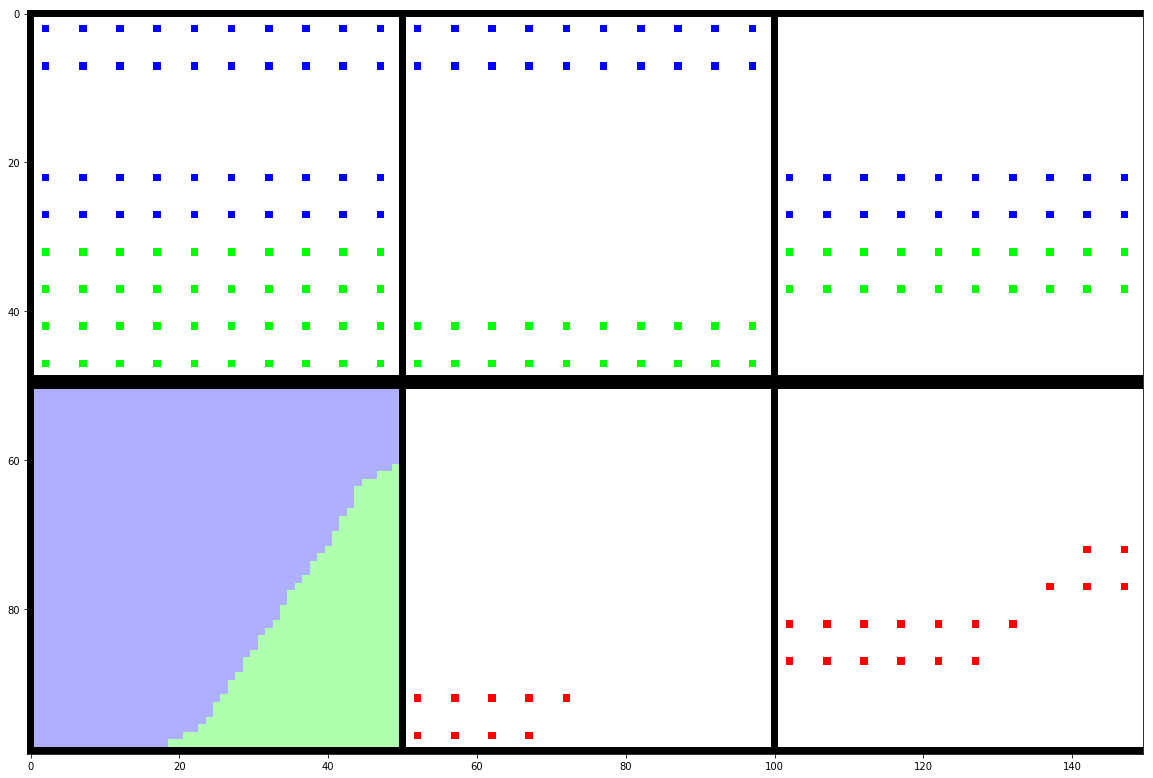

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: ignored

In [3]:
train = [
['-','-','-','-','-','-','-','-','-','-'],
['-','-','-','-','-','-','-','-','-','-'],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
['+','+','+','+','+','+','+','+','+','+'],
['+','+','+','+','+','+','+','+','+','+']]

test = [
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
['-','-','-','-','-','-','-','-','-','-'],
['-','-','-','-','-','-','-','-','-','-'],
['+','+','+','+','+','+','+','+','+','+'],
['+','+','+','+','+','+','+','+','+','+'],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']]

observe_network_behaviour_on_griddata(train,test)


malheureusement de cette fonction on ne connait qu'un certain nombre d'échantillons

In [0]:
samples = np.random.randint(0,50, size=(50,2))

et, à partir de ces échantillons seulement, on veut estimer la fonction (ce qui est impossible dans l'absolue mais qui peut marcher en pratique vue que les fonctions qu'on cherche à estimer son *régulière*).
Pour cela on définit un réseau :

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 30, bias=True)
        self.fc2 = nn.Linear(30, 30, bias=True)
        self.fc2bis = nn.Linear(30, 30, bias=True)
        self.fc3 = nn.Linear(30, 2, bias=True)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x/30))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc2bis(x))
        x = self.fc3(x)
        return x

    def forwardnp(self,x):
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variableoutput = self.forward(variablex)
        return variableoutput.cpu().data.numpy()

model = Net()
model.train()


Net(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc2bis): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)

et on va apprendre sur les échantillons

ici juste quelques fonctions d'affichage 

In [0]:
def visualizemodel(model,visufond,visusample):
    grid = np.zeros((gridsize,gridsize,3),dtype=int)
    grid[:]=255

    batch = np.zeros((gridsize*gridsize,2),dtype=int)
    for row in range(gridsize):
        for col in range(gridsize):
            batch[row*gridsize+col][0]=row
            batch[row*gridsize+col][1]=col

    prob = model.forwardnp(batch)
    pred = np.argmax(prob,axis=1)

    if visufond:
        grid[:,:,0]=175
        for row in range(gridsize):
            for col in range(gridsize):
                if pred[row*gridsize+col]==1:
                    grid[row][col][1] = 175
                else:
                    grid[row][col][2] = 175

    if visusample:
        for row,col in samples:
            grid[row][col][0]=0
            if pred[row*gridsize+col]==1:
                grid[row][col][1] = 0
            else:
                grid[row][col][2] = 0

    return np.uint8(grid),pred

def visualizeALL():
    gt,gtpred = visualizemodel(groundtruth,True,False)
    justsamples,_ = visualizemodel(groundtruth,False,True)
    model.eval()
    modelout,pred = visualizemodel(model,True,True)
    model.train()
    
    samplemask = np.zeros(gridsize*gridsize,dtype=int)
    for row,col in samples:
        samplemask[row*gridsize+col] = 1
    realerror = np.sum(np.absolute(gtpred-pred))
    observederror = np.sum(np.absolute(gtpred-pred)*samplemask)
    
    return np.concatenate((gt,justsamples,modelout), axis=1),realerror,observederror
  

les paramètres de l'apprentissage

In [0]:
lr = 0.1
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
losslayer = nn.CrossEntropyLoss()
nbepoch = 200

l'apprentissage

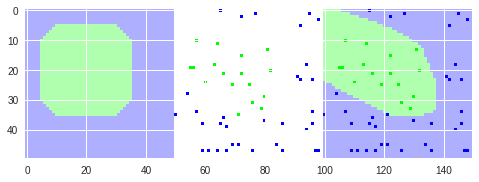

real error= 901 	observed error on samples= 17 	optimisation loss= 0.5872671
real error= 901 	observed error on samples= 17 	optimisation loss= 0.58501065
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5826737
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5802513
real error= 901 	observed error on samples= 17 	optimisation loss= 0.577759
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5751996
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5725545
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5698205
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5669856
real error= 901 	observed error on samples= 17 	optimisation loss= 0.5640572
real error= 901 	observed error on samples= 17 	optimisation loss= 0.56101984
real error= 928 	observed error on samples= 17 	optimisation loss= 0.5578815
real error= 954 	observed error on samples= 17 	optimisation loss= 0.554658

In [0]:
from IPython.display import clear_output # command to clear the figures
from time import sleep

allprints = []
for epoch in range(nbepoch):
    batch = torch.autograd.Variable(torch.Tensor(samples.astype(float)).float())
    target = torch.autograd.Variable(torch.from_numpy(np.argmax(groundtruth.forwardnp(samples),axis=1)).long())

    optimizer.zero_grad()
    output = model(batch)

    loss = losslayer(output, target)
    loss.backward()
    optimizer.step()
    
    
    grid,realerror,observederror = visualizeALL()
    allprints.append(("real error=",realerror,"\tobserved error on samples=", observederror, "\toptimisation loss=", loss.cpu().data.numpy()))
    
    if epoch%8==0:
        #show how it learn
        clear_output()
        plt.imshow(grid)
        plt.show()
        sleep(1)

#print all the log at the end of the loop (otherwise you do not see the plot)
for a,b,c,d,e,f in allprints:
    print(a,b,c,d,e,f)